## Gradient scaling tests

- Importation of the required modules

In [1]:
import copy
import logging
import os
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path
from typing import (
    Dict,
    Generator,
    Iterable,
    List,
    Sequence,
    Tuple,
    Union,
    Optional,
    Iterator,
)
import matplotlib as mpl
import matplotlib.pyplot as plt
import nested_grid_plotter as ngp
import numpy as np
import pyrtid
import pyrtid.inverse as dminv
import scipy as sp
from pyrtid.utils.types import NDArrayFloat

In [2]:
from typing import Literal, Any
from pyrtid.inverse.preconditioner import (
    Preconditioner,
    ChainedTransforms,
    LinearTransform,
)
import stochopy

- Set-up logging level

In [3]:
logger = logging.getLogger("SCALER")
logger.setLevel(logging.INFO)
logging.info("this is a logging test")
print("This is a print test")

This is a print test


- Check package/software versions

In [4]:
pyrtid.utils.show_versions()

In [5]:
def scale_pcd(scaling_factor: float, pcd: Preconditioner) -> Preconditioner:
    """Scale the given preconditioner with the scaling factor."""
    return ChainedTransforms(
        [copy.copy(pcd), LinearTransform(slope=scaling_factor, y_intercept=0.0)]
    )


def get_max_update(
    pcd: Preconditioner, s_nc: NDArrayFloat, grad_nc: NDArrayFloat
) -> float:
    """
    Get the max update of parameter values with gradient descent on conditioned values.

    Parameters
    ----------
    pcd : Preconditioner
        Preconditioner.
    s_nc : NDArrayFloat
        Non conditioned parameter values.
    grad_nc : NDArrayFloat
        Gradient of the objective function with respect to the non conditioned parameter
        values.

    Returns
    -------
    float
        Maximum update of the parameter values.
    """
    pcd = copy.copy(pcd)
    s_cond = pcd(s_nc)
    return float(
        sp.linalg.norm(
            pcd.backtransform(s_cond - pcd.dbacktransform_vec(s_cond, grad_nc)) - s_nc,
            ord=np.inf,
        )
    )


def get_max_update_wrapper(
    scaling_factor: float,
    pcd: Preconditioner,
    s_nc: NDArrayFloat,
    grad_nc: NDArrayFloat,
) -> float:
    """
    Get the max update of parameter values with gradient descent on conditioned values.

    Parameters
    ----------
    pcd : Preconditioner
        Preconditioner.
    s_nc : NDArrayFloat
        Non conditioned parameter values.
    grad_nc : NDArrayFloat
        Gradient of the objective function with respect to the non conditioned parameter
        values.

    Returns
    -------
    float
        Maximum update of the parameter values.
    """
    return get_max_update(scale_pcd(scaling_factor, pcd), s_nc, grad_nc)


# def cost_fun(
#     scaling_factor: float,
#     pcd: Preconditioner,
#     s_nc: NDArrayFloat,
#     grad_nc: NDArrayFloat,
#     max_s_nc_update_target,
# ) -> float:
#     return np.log(
#         (
#             get_max_update(scale_pcd(scaling_factor, pcd), s_nc=s_nc, grad_nc=grad_nc)
#             - max_s_nc_update_target
#         )
#         ** 2
#         + 1.0
#     )  # Add 1.0 because of the log


def get_relative_error(x: float, x_ref: float) -> float:
    """
    Get the relative error between x and the reference x_ref.

    Parameters
    ----------
    x : float
        Value.
    x_ref : float
        Reference value.

    Returns
    -------
    float
        Relative error between x and x_ref.
    """
    return (x - x_ref) / x_ref


def scale_preconditioned_gradient(
    s_nc: NDArrayFloat,
    grad_nc: NDArrayFloat,
    pcd: Preconditioner,
    max_s_nc_update_target: float,
    max_workers=10,
    rtol: float = 0.05,
    logger: Optional[logging.Logger] = None,
) -> Preconditioner:
    """
    Add a LinearTransform to the precondition gradient to ensure a defined update.

    HERE: add the maths.

    Parameters
    ----------
    s_nc : NDArrayFloat
        Non conditioned parameter values.
    grad_cond : NDArrayFloat
        Conditioned gradient.
    pcd : Preconditioner
        Preconditioner instance
    max_s_nc_update_target : float
        Maximum update desired on the non-conditioned parameter values.
    method: Literal["cmaes","cpso", "de", "na", "pso", "vdcma"]
        Type of solver (from :module:`stochopy`) to chose among:
        - cmaes
        - cpso
        - de
        - na
        - pso
        - vdcma
        The default is cmaes.
    solver_options: Optional[Dict[str, Any]]
        Options for the solver overwriting the defaults: `{"maxiter": 50, "popsize": 5,
        "seed": 0}`. The default is None.

    Returns
    -------
    Preconditioner
        The updated preconditioner with the linear transform.
    """
    if logger is not None:
        logger.info("Scaling the preconditioned gradient!")
        init_max_change = get_max_update(
            copy.copy(pcd),
            s_nc,
            grad_nc,
        )
        logger.info(f"Initial scaling factor = 1.0")
        logger.info(f"Initial maximum change   = {init_max_change:.2e}")
        logger.info(f"Objective maximum change = {max_s_nc_update_target:.2e}\n")

    # step 1: explore
    scaling_factor = 1.0  # initial guess
    lb = 1e-10  # initial lower bound
    ub = 1e10  # initial upper bound
    round = 1

    def get_pcd() -> Generator:
        while True:
            yield copy.copy(pcd)

    def get_s_nc() -> Generator:
        while True:
            yield s_nc

    def get_grad_nc() -> Generator:
        while True:
            yield grad_nc

    while (
        np.abs(
            get_relative_error(
                get_max_update(
                    scale_pcd(scaling_factor, pcd),
                    s_nc,
                    grad_nc,
                ),
                max_s_nc_update_target,
            )
        )
        > rtol
    ):
        if round == 6:
            raise RuntimeError(
                "Did not converge in 5 rounds! The update target might not be feasible for the given preconditioner."
            )

        if logger is not None:
            logger.info(f"Optimization round {round}")
            logger.info(f"lower bound   = {lb:.2e}")
            logger.info(f"upper bound   = {ub:.2e}")

        scaling_factors = np.logspace(
            np.log10(lb), np.log10(ub), 50 - (round - 1) * 10, base=10
        )

        if max_workers == 1:
            max_s_nc_updates: List[float] = []
            for _scaling_factor in scaling_factors:
                max_s_nc_updates.append(
                    get_max_update(
                        scale_pcd(_scaling_factor, copy.copy(pcd)), s_nc, grad_nc
                    )
                )
        else:
            with ProcessPoolExecutor(max_workers=max_workers) as executor:
                max_s_nc_updates = list(
                    executor.map(
                        get_max_update_wrapper,
                        scaling_factors,
                        get_pcd(),
                        get_s_nc(),
                        get_grad_nc(),
                    )
                )

        squared_diff = (np.array(max_s_nc_updates) - max_s_nc_update_target) ** 2
        argmin = np.argmin(np.log(squared_diff + 1.0))
        scaling_factor = scaling_factors[argmin]
        if argmin == 0:
            lb = scaling_factor
        else:
            lb = scaling_factors[argmin - 1]
        if argmin == len(scaling_factors) - 1:
            ub = scaling_factor
        else:
            ub = scaling_factors[argmin + 1]

        if logger is not None:
            logger.info(f"Post round {round}: Scaling factor  = {scaling_factor:.2e}")
            logger.info(
                f"Post round {round}: Max s_nc change = {max_s_nc_updates[argmin]:.2e}"
            )
            _re = get_relative_error(max_s_nc_updates[argmin], max_s_nc_update_target)
            logger.info(f"Post round {round}: Rel. error to target = {_re:.2%}\n")

        # update the round number
        round += 1

    return ChainedTransforms(
        [copy.copy(pcd), LinearTransform(slope=scaling_factor, y_intercept=0.0)]
    )

In [6]:
from pyrtid.inverse.preconditioner import (
    Preconditioner,
    LinearTransform,
    ChainedTransforms,
    # scale_preconditioned_gradient
)

s_nc = np.ones(10) * 0.1  # 0.1
grad_nc = np.ones_like(s_nc) * 0.1  # 1.0
max_s_nc_update_target = 0.8
pcd_lin = dminv.LinearTransform(slope=50.0, y_intercept=0.0)
rtol = 1e-2  # 1 percent precision

initial_max_update = get_max_update(pcd_lin, s_nc, grad_nc)
logger.info(f"Initial_max_update = {initial_max_update}\n")

new_pcd = scale_preconditioned_gradient(
    s_nc,
    grad_nc,
    pcd_lin,
    max_s_nc_update_target=max_s_nc_update_target,
    rtol=rtol,
    logger=logger,
)
new_max_update = get_max_update(new_pcd, s_nc, grad_nc)
print(f"New_max_update = {new_max_update}")

np.testing.assert_allclose(new_max_update, max_s_nc_update_target, rtol=rtol)

INFO:SCALER:Initial_max_update = 3.999999999999837e-05

INFO:SCALER:Scaling the preconditioned gradient!
INFO:SCALER:Initial scaling factor = 1.0
INFO:SCALER:Initial maximum change   = 4.00e-05
INFO:SCALER:Objective maximum change = 8.00e-01

INFO:SCALER:Optimization round 1
INFO:SCALER:lower bound   = 1.00e-10
INFO:SCALER:upper bound   = 1.00e+10


INFO:SCALER:Post round 1: Scaling factor  = 5.69e-03
INFO:SCALER:Post round 1: Max s_nc change = 1.24e+00
INFO:SCALER:Post round 1: Rel. error to target = 54.44%

INFO:SCALER:Optimization round 2
INFO:SCALER:lower bound   = 2.22e-03
INFO:SCALER:upper bound   = 1.46e-02
INFO:SCALER:Post round 2: Scaling factor  = 7.07e-03
INFO:SCALER:Post round 2: Max s_nc change = 8.01e-01
INFO:SCALER:Post round 2: Rel. error to target = 0.09%



New_max_update = 0.8007055968089608


In [7]:
from pyrtid.utils.finite_differences import is_gradient_correct


def dlog(x: float, dx: float) -> float:
    """Return the derivative of log(x)."""
    return 1 / x * dx


def dexp(x: float, dx: float) -> float:
    """Return the derivative of log(x)."""
    return np.exp(x) * dx


def dsquare(x: float, dx: float) -> float:
    return 2.0 * x * dx


def dlog(x: float, dx: float) -> float:
    """Return the derivative of log(x)."""
    return 1 / x * dx


def inf_norm(scaling_factor: float, *, x: NDArrayFloat) -> float:
    return sp.linalg.norm(scaling_factor * x, ord=np.inf)


def d_inf_norm(scaling_factor: float, *, x: NDArrayFloat) -> float:
    """Return the derivative of the infinite norm."""
    argmax = np.argmax(np.abs(x))
    return np.sign(x[argmax]) * x[argmax]


def dget_max_update_dscaling_factor(
    scaling_factor: float,
    pcd: Preconditioner,
    s_nc: NDArrayFloat,
    grad_nc: NDArrayFloat,
) -> float:
    """
    Return the derivative of get_max_update with respect to scaling_factor.

    Parameters
    ----------
    scaling_factor: float
        Scaling factor multiplying the non conditoned parameter values.
    pcd : Preconditioner
        Preconditioner.
    s_nc : NDArrayFloat
        Non conditioned parameter values.
    grad_nc : NDArrayFloat
        Gradient of the objective function with respect to the non conditioned parameter
        values.

    Returns
    -------
    float
        _description_
    """
    new_pcd = ChainedTransforms(
        [copy.copy(pcd), LinearTransform(slope=np.exp(scaling_factor), y_intercept=0.0)]
    )
    s_cond = new_pcd(s_nc)
    return float(
        sp.linalg.norm(
            new_pcd.backtransform(s_cond - new_pcd.dbacktransform_vec(s_cond, grad_nc))
            - s_nc,
            ord=np.inf,
        )
    )


kwargs = {"x": np.random.default_rng(2024).normal(size=10)}

is_gradient_correct(
    np.array([2.0]), inf_norm, d_inf_norm, fm_kwargs=kwargs, grad_kwargs=kwargs
)

True

In [8]:
# This works!
# def get_max_update(
#     scaling_factor: float, *, pcd: Preconditioner, s_nc: NDArrayFloat, grad_nc: NDArrayFloat
# ) -> float:
#     return sp.linalg.norm(np.exp(scaling_factor) * s_nc, ord=np.inf)


# def dget_max_update_dscaling_factor(
#     scaling_factor: float, *, pcd: Preconditioner, s_nc: NDArrayFloat, grad_nc: NDArrayFloat
# ) -> float:
#     """Return the derivative of the infinite norm."""
#     x = s_nc
#     argmax = np.argmax(np.abs(x))
#     return np.sign(x[argmax]) * x[argmax] * np.exp(scaling_factor)


# def cost_fun(
#     scaling_factor: float,
#     *,
#     pcd: Preconditioner,
#     s_nc: NDArrayFloat,
#     grad_nc: NDArrayFloat,
#     max_s_nc_update_target,
# ) -> float:
#     return np.log(
#         (
#             get_max_update(scaling_factor, pcd=pcd, s_nc=s_nc, grad_nc=grad_nc)
#             - max_s_nc_update_target
#         )
#         ** 2
#         + 1.0
#     )  # Add 1.0 because of the log


# def dcost_fun_dscaling_factor(
#     scaling_factor: float,
#     *,
#     pcd: Preconditioner,
#     s_nc: NDArrayFloat,
#     grad_nc: NDArrayFloat,
#     max_s_nc_update_target,
# ) -> float:
#     t = (
#         get_max_update(scaling_factor, pcd=pcd, s_nc=s_nc, grad_nc=grad_nc)
#         - max_s_nc_update_target
#     )
#     return dlog(
#         t**2 + 1,
#         dsquare(t, dget_max_update_dscaling_factor(scaling_factor, pcd=pcd, s_nc=s_nc, grad_nc=grad_nc)),
#     )


def get_max_update2(
    scaling_factor: float,
    *,
    pcd: Preconditioner,
    s_nc: NDArrayFloat,
    grad_nc: NDArrayFloat,
) -> float:
    scale = scaling_factor
    # new_pcd = ChainedTransforms(
    #     [copy.copy(pcd), LinearTransform(slope=scale, y_intercept=0.0)]
    # )
    new_pcd = copy.copy(pcd)
    s_cond = new_pcd(s_nc * scale)
    # TODO: function new_pcd.ddbacktransfrom
    # tmp = new_pcd.backtransform(s_cond - new_pcd.dbacktransform_vec(s_cond, grad_nc)) - s_nc
    tmp = s_cond - s_nc

    return sp.linalg.norm(tmp, ord=np.inf)
    # return sp.linalg.norm(tmp, ord=np.inf)

    # return sp.linalg.norm(np.exp(scaling_factor) * s_nc, ord=np.inf)


def dget_max_update2_dscaling_factor(
    scaling_factor: float,
    *,
    pcd: Preconditioner,
    s_nc: NDArrayFloat,
    grad_nc: NDArrayFloat,
) -> float:
    """Return the derivative of the infinite norm."""
    scale = scaling_factor
    dscale = 1.0
    # argmax = np.argmax(np.abs(x))
    # return np.sign(x[argmax]) * x[argmax] * np.exp(scaling_factor)
    # new_pcd = ChainedTransforms(
    #     [copy.copy(pcd), LinearTransform(slope=np.exp(scaling_factor), y_intercept=0.0)]
    # )
    new_pcd = copy.copy(pcd)

    s_cond = new_pcd(scale * s_nc)
    ds_cond_dscaling_factor = new_pcd.dtransform_vec(s_nc * scale, s_nc)
    tmp = s_cond
    dtmp = ds_cond_dscaling_factor
    argmax = np.argmax(np.abs(tmp))

    return np.sign(tmp)[argmax] * dtmp[argmax]


def cost_fun2(
    scaling_factor: float,
    *,
    pcd: Preconditioner,
    s_nc: NDArrayFloat,
    grad_nc: NDArrayFloat,
    max_s_nc_update_target,
) -> float:
    return np.log(
        (
            get_max_update2(scaling_factor, pcd=pcd, s_nc=s_nc, grad_nc=grad_nc)
            - max_s_nc_update_target
        )
        ** 2
        + 1.0
    )  # Add 1.0 because of the log


def dcost_fun2_dscaling_factor(
    scaling_factor: float,
    *,
    pcd: Preconditioner,
    s_nc: NDArrayFloat,
    grad_nc: NDArrayFloat,
    max_s_nc_update_target,
) -> float:
    t = (
        get_max_update2(scaling_factor, pcd=pcd, s_nc=s_nc, grad_nc=grad_nc)
        - max_s_nc_update_target
    )
    return dlog(
        t**2 + 1,
        dsquare(
            t,
            dget_max_update2_dscaling_factor(
                scaling_factor, pcd=pcd, s_nc=s_nc, grad_nc=grad_nc
            ),
        ),
    )


max_s_nc_update_target = 0.2
kwargs = {
    "pcd": pcd_lin,
    "s_nc": s_nc,
    "grad_nc": grad_nc,
    "max_s_nc_update_target": max_s_nc_update_target,
}
is_gradient_correct(
    np.array([0.5]),
    cost_fun2,
    dcost_fun2_dscaling_factor,
    fm_kwargs=kwargs,
    grad_kwargs=kwargs,
)

True

In [9]:
def get_max_update_scaling_factor(
    scaling_factor: float,
    pcd: Preconditioner,
    s_nc: NDArrayFloat,
    grad_nc: NDArrayFloat,
) -> float:
    """

    Parameters
    ----------
    scaling_factor: float
        Scaling scalar for parameter.
    pcd : Preconditioner
        _description_
    s_nc : NDArrayFloat
        _description_
    grad_nc : NDArrayFloat
        _description_

    Returns
    -------
    float
        _description_
    """
    new_pcd = ChainedTransforms(
        [copy.copy(pcd), LinearTransform(slope=np.exp(scaling_factor), y_intercept=0.0)]
    )
    s_cond = new_pcd(s_nc)
    return float(
        sp.linalg.norm(
            new_pcd.backtransform(s_cond - new_pcd.dbacktransform_vec(s_cond, grad_nc))
            - s_nc,
            ord=np.inf,
        )
    )

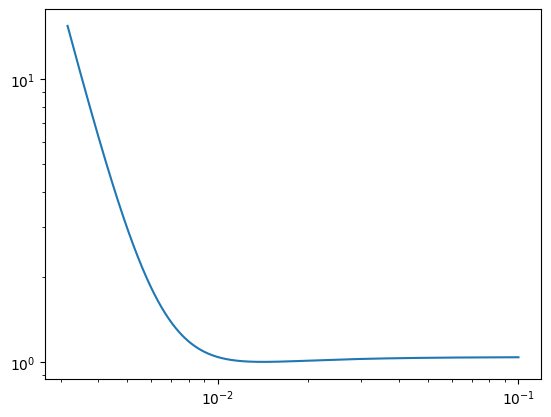

In [10]:
x = np.logspace(-2.5, -1, 1000, base=10)
y = []
for _x in x:
    y.append(
        (get_max_update(scale_pcd(_x, pcd_lin), s_nc, grad_nc) - max_s_nc_update_target)
        ** 2
        + 1.0
    )

plt.plot(x, y)
plt.xscale("log")
plt.yscale("log")

In [11]:
x[np.argmin(y)]

0.014130259905995337

In [12]:
from contextlib import nullcontext as does_not_raise

import numdifftools as nd
import numpy as np
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
import pyrtid.utils.spde as spde
import pytest
from pyrtid.inverse.preconditioner import (
    get_theta_init_normal,
    get_theta_init_uniform,
)
from pyrtid.utils import (
    NDArrayFloat,
    NDArrayInt,
    indices_to_node_number,
    sparse_cholesky,
)
from scipy._lib._util import check_random_state  # To handle random_state

In [13]:
is_update_mean = False

ne = 100
# Grid
nx = 20  # number of voxels along the x axis
ny = 20  # number of voxels along the y axis
nz = 1
dx = 5.0  # voxel dimension along the x axis
dy = 5.0  # voxel dimension along the y axis
dz = 5.0

len_scale = 20.0  # m
kappa = 1 / len_scale
scaling_factor = 1.0

mean = 100.0  # trend of the field
std = 150.0  # standard deviation of the field

# Create a precision matrix
Q_ref = spde.get_precision_matrix(
    nx, ny, nz, dx, dy, dz, kappa, scaling_factor, spatial_dim=2, sigma=std
)
cholQ_ref = sparse_cholesky(Q_ref)
# Non conditional simulation -> change the random state to obtain a different field
simu_ = spde.simu_nc(cholQ_ref, random_state=2026).reshape(ny, nx).T
reference_grade_ppm = np.abs(simu_ + mean)

# Conditioning data
_ix = np.array([int(nx / 4), 2 * int(nx / 4), 3 * int(nx / 4)])
_iy = np.array([int(ny / 5), 2 * int(ny / 5), 3 * int(ny / 5), 4 * int(ny / 5)])
dat_coords = np.array(np.meshgrid(_ix, _iy)).reshape(2, -1)
# Get the node numbers
dat_nn: NDArrayInt = indices_to_node_number(dat_coords[0, :], nx, dat_coords[1, :])
dat_val = reference_grade_ppm.ravel("F")[dat_nn]

# Condition with the exact data -> we assume a large noise over the data
dat_var = np.ones(dat_val.size) * (100**2)

# Generate new points with error -> some variance on the measures
dat_val_noisy = dat_val + np.sqrt(dat_var) * (
    np.random.default_rng(2048).normal(scale=0.1, size=dat_val.size)
)

# Compute the average on the data points (trend)
estimated_mean = float(np.average(dat_val_noisy))
estimated_std = float(np.std(dat_val_noisy))

scaling_factor = 1

# Create a precision matrix
Q_nc = spde.get_precision_matrix(
    nx, ny, 1, dx, dy, 1.0, kappa, scaling_factor, spatial_dim=2, sigma=estimated_std
)
Q_c = spde.condition_precision_matrix(Q_nc, dat_nn, dat_var)

# Decompose with cholesky
cholQ_nc = sparse_cholesky(Q_nc)
cholQ_c = sparse_cholesky(Q_c)

lbounds = np.ones((nx * ny)) * -1000
ubounds = np.ones((nx * ny)) * 1500
theta_test = get_theta_init_uniform(ne) * (
    1 + 0.1 * np.random.default_rng(2024).normal(size=ne - 1)
)

# Non conditional simulations
dminv.GDPNCS(
    ne, Q_nc, estimated_mean, is_update_mean=is_update_mean
)._test_preconditioner(lbounds, ubounds)
# with extra parameters
pcd_gdpncs = dminv.GDPNCS(
    ne,
    Q_nc,
    estimated_mean,
    theta=theta_test,
    cholQ_nc=cholQ_nc,
    random_state=2024,
    is_update_mean=is_update_mean,
)
s_nc = pcd_gdpncs.backtransform(theta_test)
np.testing.assert_allclose(pcd_gdpncs.theta, theta_test)
# pcd._test_preconditioner(lbounds, ubounds, eps=1e-8)
# pcd.transform_bounds(np.vstack([lbounds, ubounds]).T)

# Test gradient scaling
grad_nc = (
    np.random.default_rng(2024).normal(scale=1.0, size=(nx * ny * nz)) * 1e-5 + 2e-5
)  # 1.0
max_s_nc_update_target = 1e-1
rtol = 1e-2  # 1 percent precision

initial_max_update = get_max_update(pcd_gdpncs, s_nc, grad_nc)
print(f"initial_max_update = {initial_max_update}")

new_pcd = scale_preconditioned_gradient(
    s_nc,
    grad_nc,
    pcd_gdpncs,
    max_s_nc_update_target=max_s_nc_update_target,
    rtol=rtol,
    max_workers=1,
    logger=logger,
)
# new_pcd = ChainedTransforms([copy.copy(pcd), LinearTransform(slope=1.0, y_intercept=0.0)])
new_max_update = get_max_update(new_pcd, s_nc, grad_nc)
print(f"new_max_update = {new_max_update}")

np.testing.assert_allclose(new_max_update, max_s_nc_update_target, rtol=rtol)

INFO:SCALER:Scaling the preconditioned gradient!
INFO:SCALER:Initial scaling factor = 1.0
INFO:SCALER:Initial maximum change   = 5.90e+02
INFO:SCALER:Objective maximum change = 1.00e-01

INFO:SCALER:Optimization round 1
INFO:SCALER:lower bound   = 1.00e-10
INFO:SCALER:upper bound   = 1.00e+10


initial_max_update = 589.9730227478931


INFO:SCALER:Post round 1: Scaling factor  = 1.76e+02
INFO:SCALER:Post round 1: Max s_nc change = 3.15e-02
INFO:SCALER:Post round 1: Rel. error to target = -68.54%

INFO:SCALER:Optimization round 2
INFO:SCALER:lower bound   = 6.87e+01
INFO:SCALER:upper bound   = 4.50e+02
INFO:SCALER:Post round 2: Scaling factor  = 1.01e+02
INFO:SCALER:Post round 2: Max s_nc change = 9.53e-02
INFO:SCALER:Post round 2: Rel. error to target = -4.67%

INFO:SCALER:Optimization round 3
INFO:SCALER:lower bound   = 9.62e+01
INFO:SCALER:upper bound   = 1.06e+02
INFO:SCALER:Post round 3: Scaling factor  = 9.85e+01
INFO:SCALER:Post round 3: Max s_nc change = 1.00e-01
INFO:SCALER:Post round 3: Rel. error to target = 0.20%



new_max_update = 0.1002042053971195


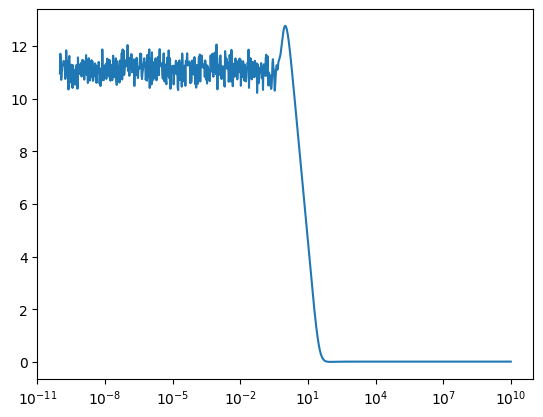

In [14]:
x = np.logspace(-10, 10, 1000, base=10)
y = []
for _x in x:
    y.append(
        np.log(
            (
                get_max_update(scale_pcd(_x, pcd_gdpncs), s_nc, grad_nc)
                - max_s_nc_update_target
            )
            ** 2
            + 1.0
        )
    )

plt.plot(x, y)
plt.xscale("log")

In [15]:
# Conditional simulations
pcd_gdpcs = dminv.GDPCS(
    ne,
    Q_nc,
    Q_c,
    estimated_mean,
    dat_nn,
    dat_val,
    dat_var,
    is_update_mean=False,
)
# pcd_gdpcs._test_preconditioner(lbounds, ubounds)
# with extra parameters
pcd_gdpcs = dminv.GDPCS(
    ne,
    Q_nc,
    Q_c,
    estimated_mean,
    dat_nn,
    dat_val,
    dat_var,
    theta=theta_test,
    cholQ_nc=cholQ_nc,
    cholQ_c=cholQ_c,
    random_state=2024,
    is_update_mean=is_update_mean,
)
pcd_gdpcs._test_preconditioner(lbounds, ubounds, rtol=1e-4, eps=1e-6)
pcd_gdpcs.transform_bounds(np.vstack([lbounds, ubounds]).T)
s_nc = pcd_gdpcs.backtransform(theta_test)
np.testing.assert_allclose(pcd_gdpcs.theta, theta_test)

grad_nc = (
    np.random.default_rng(2024).normal(scale=1.0, size=(nx * ny * nz)) * 2e1 + 3e1
)  # 1.0
max_s_nc_update_target = 100.0
rtol = 1e-2  # 1 percent precision

initial_max_update = get_max_update(pcd_gdpcs, s_nc, grad_nc)
print(f"initial_max_update = {initial_max_update}")

new_pcd = scale_preconditioned_gradient(
    s_nc,
    grad_nc,
    pcd_gdpcs,
    max_s_nc_update_target=max_s_nc_update_target,
    rtol=rtol,
    max_workers=1,
    logger=logger,
)
# new_pcd = ChainedTransforms([copy.copy(pcd), LinearTransform(slope=1.0, y_intercept=0.0)])
new_max_update = get_max_update(new_pcd, s_nc, grad_nc)
print(f"new_max_update = {new_max_update}")

# np.testing.assert_allclose(new_max_update, max_s_nc_update_target, rtol=rtol)

INFO:SCALER:Scaling the preconditioned gradient!
INFO:SCALER:Initial scaling factor = 1.0
INFO:SCALER:Initial maximum change   = 2.03e+02
INFO:SCALER:Objective maximum change = 1.00e+02

INFO:SCALER:Optimization round 1
INFO:SCALER:lower bound   = 1.00e-10
INFO:SCALER:upper bound   = 1.00e+10


initial_max_update = 203.26203414912916


INFO:SCALER:Post round 1: Scaling factor  = 1.15e+03
INFO:SCALER:Post round 1: Max s_nc change = 1.33e+02
INFO:SCALER:Post round 1: Rel. error to target = 32.97%

INFO:SCALER:Optimization round 2
INFO:SCALER:lower bound   = 4.50e+02
INFO:SCALER:upper bound   = 2.95e+03
INFO:SCALER:Post round 2: Scaling factor  = 1.36e+03
INFO:SCALER:Post round 2: Max s_nc change = 1.02e+02
INFO:SCALER:Post round 2: Rel. error to target = 2.12%

INFO:SCALER:Optimization round 3
INFO:SCALER:lower bound   = 1.30e+03
INFO:SCALER:upper bound   = 1.43e+03
INFO:SCALER:Post round 3: Scaling factor  = 1.38e+03
INFO:SCALER:Post round 3: Max s_nc change = 1.00e+02
INFO:SCALER:Post round 3: Rel. error to target = 0.17%



new_max_update = 100.16744747305535


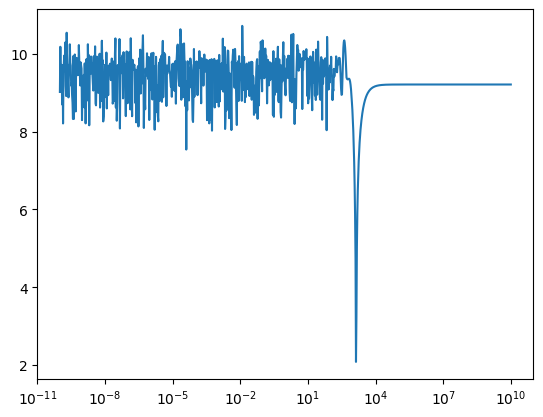

In [16]:
x = np.logspace(-10, 10, 1000, base=10)
y = []
for _x in x:
    y.append(
        np.log(
            (
                get_max_update(scale_pcd(_x, pcd_gdpcs), s_nc, grad_nc)
                - max_s_nc_update_target
            )
            ** 2
            + 1.0
        )
    )

plt.plot(x, y)
plt.xscale("log")